Données orthodontistes:

In [1]:
import pandas as pd
url = "https://mribatet.perso.math.cnrs.fr/CentraleNantes/Data/orthodontist.csv"
data = pd.read_csv(url)

In [2]:
## Only girls
data = data[data["Sex"] == "Female"]
data

Unnamed: 0  distance  age Subject     Sex
64           65      21.0    8     F01  Female
65           66      20.0   10     F01  Female
66           67      21.5   12     F01  Female
67           68      23.0   14     F01  Female
68           69      21.0    8     F02  Female
69           70      21.5   10     F02  Female
70           71      24.0   12     F02  Female
71           72      25.5   14     F02  Female
72           73      20.5    8     F03  Female
73           74      24.0   10     F03  Female
74           75      24.5   12     F03  Female
75           76      26.0   14     F03  Female
76           77      23.5    8     F04  Female
77           78      24.5   10     F04  Female
78           79      25.0   12     F04  Female
79           80      26.5   14     F04  Female
80           81      21.5    8     F05  Female
81           82      23.0   10     F05  Female
82           83      22.5   12     F05  Female
83           84      23.5   14     F05  Female
84           85      20.0    8     F06  Female
85           86      21.0   10     F06  Female
86           87      21.0   12     F06  Female
87           88      22.5   14     F06  Female
88           89      21.5    8     F07  Female
89           90      22.5   10     F07  Female
90           91      23.0   12     F07  Female
91           92      25.0   14     F07  Female
92           93      23.0    8     F08  Female
93           94      23.0   10     F08  Female
94           95      23.5   12     F08  Female
95           96      24.0   14     F08  Female
96           97      20.0    8     F09  Female
97           98      21.0   10     F09  Female
98           99      22.0   12     F09  Female
99          100      21.5   14     F09  Female
100         101      16.5    8     F10  Female
101         102      19.0   10     F10  Female
102         103      19.0   12     F10  Female
103         104      19.5   14     F10  Female
104         105      24.5    8     F11  Female
105         106      25.0   10     F11  Female
106         107      28.0   12     F11  Female
107         108      28.0   14     F11  Female

In [3]:
import numpy as np
import scipy.stats as stats

def orthodontist(nchain, data, init, hyper_prior):
    ## Gibbs sampler for the orthodontist example
    
    ## Retrieve the variables: distance, age, individuals
    distance = data["distance"]
    age = data["age"]
    nind = len(np.unique(data["Subject"]))
    ntime = len(np.unique(age))##We suppose that each individuals is followed up the same time

    individuals = np.repeat(range(nind), ntime)##create an id for each individual


    ## Retrieve the hyperparameters (of the prior distribution)
    mu_1_p = hyper_prior[0]
    sigma2_1_p = hyper_prior[1]
    mu_2_p = hyper_prior[2]
    sigma2_2_p = hyper_prior[3]
    scale_p = hyper_prior[4]
    shape_p = hyper_prior[5]
    scale_b_p = hyper_prior[6]
    shape_b_p = hyper_prior[7]    

    chain = np.zeros((nchain + 1, 4))
    latent = np.zeros((nchain + 1, nind))
    chain[0,:] = init##[beta1, beta2, sigma2, sigma2_b]

    for t in range(nchain):
        beta1, beta2, sigma2, sigma2_b = chain[t,:]
        latent_cur = latent[t,:]

        ## Update the latent variables (b_j in the model)
        for j in range(nind):
            idx = individuals == j
            c_j = distance[idx] - beta1 - beta2 * age[idx]
            m_fcond = sigma2_b * np.sum(c_j) / (ntime * sigma2_b + sigma2)
            var_fcond = sigma2_b * sigma2 / (ntime * sigma2_b + sigma2)
            latent_cur[j] = np.random.normal(loc = m_fcond, scale = np.sqrt(var_fcond))

        ## Update beta1
        tmp = np.repeat(latent_cur, ntime)##will be use several times
        cij = distance - beta2 * age - tmp
        m_fcond = (mu_1_p * sigma2 + sigma2_1_p * np.sum(cij)) / (nind * ntime * sigma2_1_p + sigma2)
        var_fcond = (sigma2_1_p * sigma2) / (nind * ntime * sigma2_1_p + sigma2)
        beta1 = np.random.normal(loc = m_fcond, scale = np.sqrt(var_fcond))

        ## Update beta2
        S2 = np.sum(age**2)
        C = np.sum(age * (distance - beta1 - tmp))
        m_fcond = (C * sigma2_2_p + mu_2_p * sigma2) / (S2 * sigma2_2_p + sigma2)
        var_fcond = (sigma2_2_p * sigma2) / (S2 * sigma2_2_p + sigma2)
        beta2 = np.random.normal(loc = m_fcond, scale = np.sqrt(var_fcond))

        ## Update of sigma2
        res = distance - beta1 - beta2 * age - tmp
        shape_fcond = 0.5 * ntime * nind + shape_p
        scale_fcond = scale_p + 0.5 * np.sum(res**2)
        sigma2 = stats.invgamma.rvs(a = shape_fcond, scale = scale_fcond)

        ## Update of sigma2_b
        shape_fcond = 0.5 * nind + shape_b_p
        scale_fcond = scale_b_p + 0.5 * np.sum(latent_cur**2)
        sigma2_b = stats.invgamma.rvs(a = shape_fcond, scale = scale_fcond)

        ## Update the chain
        chain[t+1,:] = [beta1, beta2, sigma2, sigma2_b]
        latent[t+1,:] = latent_cur
    
    return chain, latent





        

In [4]:
nchain = 10**4
init = [25, 0, 1, 1]
hyper_prior = [0, 10, 0, 10, 1, 1, 1, 1]
chain, latent = orthodontist(nchain, data, init, hyper_prior)

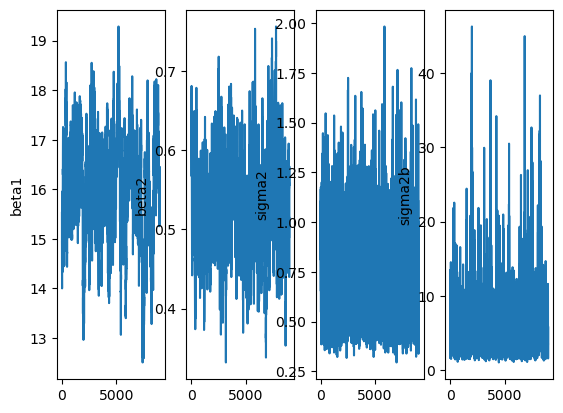

In [5]:
import matplotlib.pyplot as plt
ylabs = ["beta1", "beta2", "sigma2", "sigma2b"]
chain_burn = chain[1000:,:]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(chain_burn[:,i])
    plt.ylabel(ylabs[i])

In [6]:
## Compare predictions
post_mean = np.mean(chain, axis = 0)
post_mean_latent = np.mean(latent, axis = 0)

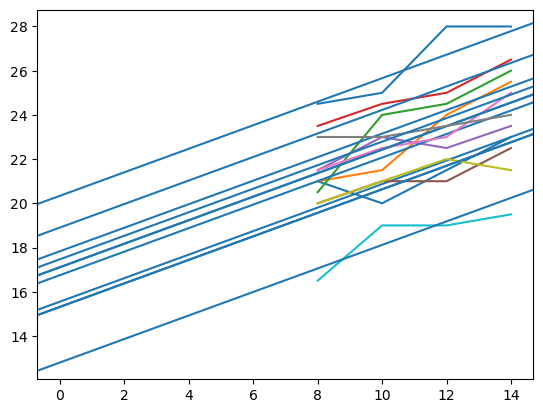

In [7]:
j = 0
for subject in np.unique(data["Subject"]):
    idx = data["Subject"] == subject
    plt.plot(data["age"][idx], data["distance"][idx])

    intersept = post_mean[0] + post_mean_latent[j]
    slope = post_mean[1]
    plt.axline((0, intersept), (1, intersept + slope))
    j += 1


Et le lien vers l'animation du kiwi qui veut à tout prix voler : https://www.youtube.com/watch?v=sdUUx5FdySs